In [2]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

In [8]:
import jax
import jax.numpy as jnp
import jax.random as jrd
import liesel.model as lsl
import pytest
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk
from liesel.goose.optim import Stopper, history_to_df

from batram.tmspat_jax.model import Model, TransformationModel, LocScaleTransformationModel
from batram.tmspat_jax.node import (
    ModelOnionCoef,
    OnionCoefPredictivePointProcessGP,
    OnionKnots,
    ModelConst,
    ModelVar
)

key = jrd.PRNGKey(42)

In [4]:
true_loc = 3.0
true_scale = 1.3
y = true_loc + true_scale * jrd.normal(key, shape=(90, 100))

locs = jrd.uniform(key, shape=(y.shape[1], 2))
knots = OnionKnots(-3.0, 3.0, nparam=12)
locs_var = lsl.Var(locs, name="locs")

coef = OnionCoefPredictivePointProcessGP.new_from_locs(
    knots,
    inducing_locs=lsl.Var(locs[:-50,:], name="inducing_locs"),
    sample_locs=locs_var,
    kernel_cls=tfk.ExponentiatedQuadratic,
    amplitude=lsl.param(1.0, name="amplitude"),
    length_scale=lsl.param(1.0, name="length_scale"),
    name="coef",
)


loc = ModelVar(0.0, name="loc")
scale = ModelVar(1.0, bijector=tfb.Softplus(), name="scale")

model = LocScaleTransformationModel(
    y[:-50, :], knots=knots.knots, coef=coef, loc=loc, scale=scale
)

In [7]:
stopper = Stopper(max_iter=1000, patience=20)

result = model.fit_parametric_distributionloc_batched(
    train=y,
    validation=y,
    locs=locs_var,
    stopper=stopper
)

Training loss: 15766.104, Validation loss: 15766.104:  59%|█████▉    | 589/999 [00:04<00:02, 203.16it/s]

In [9]:
result.position

{'loc_transformed': Array(3.0168874, dtype=float32),
 'scale_transformed': Array(1.0075155, dtype=float32)}

Training loss: 15766.104, Validation loss: 15766.104:  59%|█████▉    | 589/999 [00:20<00:02, 203.16it/s]

<Axes: xlabel='iteration'>

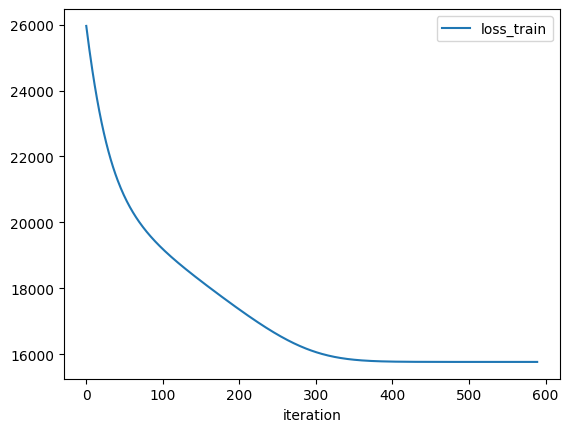

In [10]:
history_to_df(result.history)[["loss_train", "iteration"]].plot("iteration")

<Axes: xlabel='iteration'>

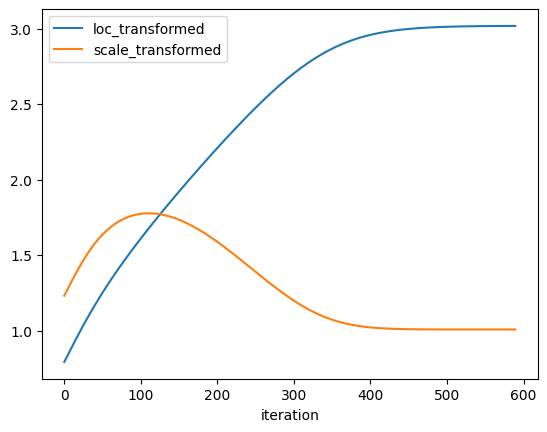

In [11]:
history_to_df(result.history)[["loc_transformed", "scale_transformed", "iteration"]].plot("iteration")

In [13]:
result.model_state["scale_value"].value

Array(1.3187616, dtype=float32)